# Experimental demonstration that the quantum ensemble prediction is equivalent to the average prediction of the single classifiers

### Import functions and packages

In [2]:
import sys

sys.path.insert(1, '../')

from Utils import *
from modeling import *

seed = random.randint(1, 10000)
np.random.seed(seed)
print('seed:', seed)

n_shots = 100
p1_avg = []
p1_ens = []

N_runs = 50

seed: 8463


In [12]:
y_labels =[[0,1], [1,0]]

A each iteration we generate a random balanced training set of four observations and a test set of one observation. Thus, we compute the four possible cosine predictions and average them. We also comput the ensmeble prediction and compare the results.

In [13]:
for run in np.arange(N_runs):
    # print(run)
    x1 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x1_train = normalize_custom(x1_train) # y1 = '1'
    x2 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x2_train = normalize_custom(x2_train) # y2 = '0'
    x3 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x3_train = normalize_custom(x3_train) # y3 = '1'
    x4 = [np.random.randint(1, 9), np.random.randint(1, 9)]#; x4_train = normalize_custom(x4_train) # y4 = '0'
    
    y1 = y_labels[np.random.randint(0, 2)]
    y2 = y_labels[np.random.randint(0, 2)]
    y3 = y_labels[np.random.randint(0, 2)]
    y4 = y_labels[np.random.randint(0, 2)]
    
    Y_data = [y1, y2, y3, y4]  
    X_data = [x1, x2, x3, x4]
    
    x_test = [np.random.randint(-9, 9), np.random.randint(-9, 9)]#; x_test = normalize_custom(x_test)

    X_data, Y_data, x_test = load_data_custom(X_data, Y_data, x_test = x_test)

    qc1 = cos_classifier(X_data[0], x_test, Y_data[0] )
    r1 = exec_simulator(qc1)
    r1 = retrieve_proba(r1)

    qc2 = cos_classifier(X_data[1], x_test, Y_data[1])
    r2 = exec_simulator(qc2)
    r2 = retrieve_proba(r2)

    qc3 = cos_classifier(X_data[2], x_test, Y_data[2])
    r3 = exec_simulator(qc3)
    r3 = retrieve_proba(r3)

    qc4 = cos_classifier(X_data[3], x_test, Y_data[3])
    r4 = exec_simulator(qc4)
    r4 = retrieve_proba(r4)
     
    out = [r1, r2, r3, r4]

    p0 = [p[0] for p in out]
    p1 = [p[1] for p in out]
    
    r_avg = [np.mean(p0), np.mean(p1)]
    # print('AVG:', r_avg)

    
    qc = ensemble_fixed_U(X_data, Y_data, x_test)
    qc = transpile(qc, basis_gates = ['u1', 'u2', 'u3', 'cx'], optimization_level=3)

    r = exec_simulator(qc, n_shots=n_shots)
    r_ens = retrieve_proba(r)
    # print('Ensemble', r_ens)

    out = [r1, r2, r3, r4, r_avg, r_ens]
    
    p1_avg.append(r_avg[1])
    p1_ens.append(r_ens[1])

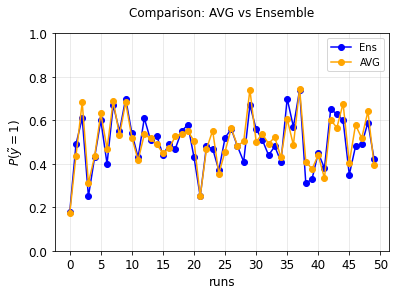

In [14]:
plt.plot(np.arange(N_runs), p1_ens, marker='o', color='blue', label='Ens')
plt.plot(np.arange(N_runs), p1_avg, marker='o', color='orange', label = 'AVG')
plt.title('Comparison: AVG vs Ensemble', size=12).set_position([.5, 1.05])
plt.xlabel('runs', size=12)
plt.ylabel(r'$P(\tilde{y}=1)$', size =12)
plt.xticks(np.arange(0, N_runs+1, 5), size = 12)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], size = 12)
plt.ylim(0,1)
plt.grid(alpha=.3)
plt.legend()
plt.savefig('output/multi_run_fixed.png', dpi = 300)

In [15]:
ttest_ind(p1_ens, p1_avg)

Ttest_indResult(statistic=-0.37139100553386617, pvalue=0.7111480466260728)

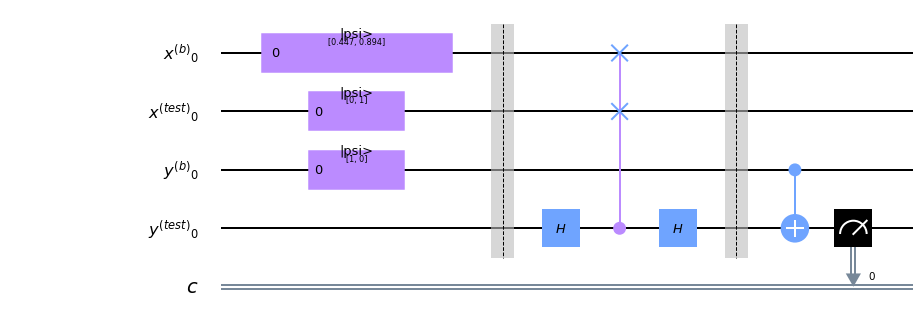

In [16]:
qc1.draw(output='mpl', scale=.9)

# Behaviour of quantum cosine classifiers on 1000 random generated datasets

In [3]:
n_shots = 1000
n=1000
x = []
x_err = []
P0 = []
P1 = []

for i in np.arange(n):
    '''Random generated vectors'''
    x_train = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_train_norm = normalize_custom(x_train)
    x_test = [random.uniform(-1, 1), random.uniform(0, 1)]
    x_test_norm = normalize_custom(x_test)

    '''Compute cosine distance and append it to x'''
    d_cos = cosine_similarity([x_train], [x_test])[0][0]
    x.append(d_cos)

    '''If x_train belongs to class 0'''
    qc = cos_classifier(x_train_norm, x_test_norm, [1,0])
    r = exec_simulator(qc, n_shots)
    P_q = r['0']/n_shots
    P0.append(P_q)
    d_cos_err = np.sqrt(2*P_q-1)
    x_err.append( d_cos_err )


P0 = np.array(P0)
x = np.array(x)
x_err = np.array(x_err)

order = x.argsort()

x = x[order[::-1]]
P0 = P0[order[::-1]]
x_err = x_err[order[::-1]]

err = [ abs(x1 - x2) for (x1, x2) in zip(abs(x), x_err)]
err = np.array(err)
P1 = 1-P0

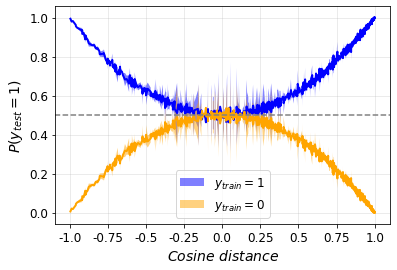

In [7]:
fig, ax = plt.subplots(1)
ax.plot(x, P0 , lw=2, color='blue')
ax.fill_between(x, P0 - err, P0 + err, facecolor = 'blue', label='$y_{train} = 1$', alpha=0.5)
ax.plot(x, P1 , lw=2, color='orange')
ax.fill_between(x, P1 - err, P1 + err, facecolor = 'orange', label='$y_{train} = 0$' , alpha=0.5)
#ax.plot(q, mean, lw=2, label = str(np.round(err, 1)), color=color)
#ax.fill_between(q, mean + upper, mean - lower, facecolor=color, alpha=0.5)
#ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
#ax.set_title(r'Quantum cosine classifier', size=14).set_position([.5, 1.05])
ax.legend(loc='center lower', prop=dict(size=12))
ax.set_xlabel('$Cosine$ $distance$', size = 14)
ax.set_ylabel('$P(y_{test} = 1)$',size = 14)
ax.axhline(y=.5, xmin=-1, xmax=1, color = 'gray', linestyle = '--')
ax.set_xticklabels([0, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00], size=12)
#ax.set_yticklabels([0, .2, .4, 0.2, 0.3, 0.4, 0.5], size=12)
ax.set_yticklabels([0, 0.0, .2, .4, .6, 0.8, 1.0], size=12)
ax.grid(alpha=.3)
plt.savefig('output/cos_classifier_behaviour.png', dpi = 300, bbox_inches='tight')
plt.show()